<a href="https://colab.research.google.com/github/fintech-projects/google-colab/blob/main/Finger_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the key libraries

In [ ]:
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import io

print (tf.__version__)

2.6.0


# Importing the data

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d koryakinp/fingers
from zipfile import ZipFile
file_name = "fingers.zip"

Saving kaggle.json to kaggle.json
 97% 354M/363M [00:06<00:00, 60.5MB/s]
100% 363M/363M [00:07<00:00, 53.9MB/s]


In [ ]:
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Organizing the data into folders

In [ ]:
import glob

Pngfiles_Train = []
Pngfiles_Test = []

os.chdir('/content/train')

for files in glob.glob("*.png"):
  Pngfiles_Train.append(files)

os.chdir('/content/test')

for files in glob.glob("*.png"):
  Pngfiles_Test.append(files)

In [ ]:
Classes = ['0L', '1L', '2L', '3L', '4L', '5L', '0R', '1R', '2R', '3R', '4R', '5R']

if not os.path.exists('/content/Train'):
  os.mkdir('/content/Train')

if not os.path.exists('/content/Test'):
  os.mkdir('/content/Test')

In [ ]:
for i in Classes:
  if not os.path.exists('/content/Train/'+i):
    os.mkdir('/content/Train/'+i)

for i in Classes:
  if not os.path.exists('/content/Test/'+i):
    os.mkdir('/content/Test/'+i)

In [ ]:
# Training set

import shutil

os.chdir('/content/train') # change directory for train data

for i in Pngfiles_Train:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Train/{}'.format(last_two))

os.chdir('/content/test') # change directory for testing data
for i in Pngfiles_Test:
  last_two = i[-6:-4]
  shutil.copy(i, '/content/Test/{}'.format(last_two))

# Importing the Training dataset

In [ ]:
Batch_size = 32
Image_size = (128,128)

training_set = tf.keras.preprocessing.image_dataset_from_directory(directory = '/content/Train',
                                                                   batch_size = Batch_size,
                                                                   image_size = Image_size,
                                                                   label_mode = 'categorical')

Found 18000 files belonging to 12 classes.


### Visualizing the imported results

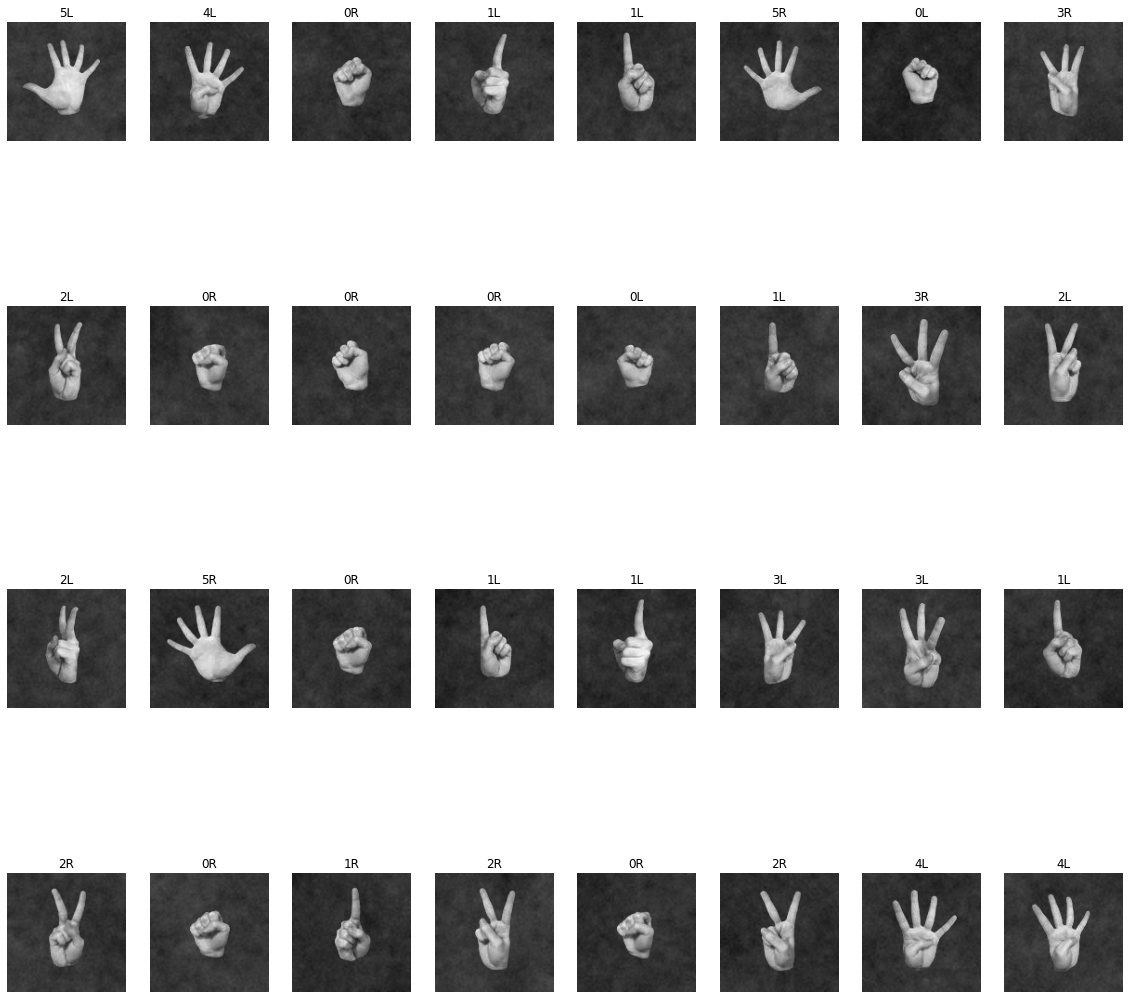

In [ ]:
class_names = training_set.class_names

plt.figure(figsize = (20,20))

for image, label in training_set.take(1):
  for i in range(0,32):
    plt.subplot(4,8,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[np.where(label[i].numpy() == 1)[0][0]])
    plt.axis('off')

plt.show()

# Importing the Test dataset

In [ ]:
Batch_size = 32
Image_size = (128,128)

test_set = tf.keras.preprocessing.image_dataset_from_directory(directory = '/content/Test',
                                                                   batch_size = Batch_size,
                                                                   image_size = Image_size,
                                                                   label_mode = 'categorical')

Found 3600 files belonging to 12 classes.


### Splitting the Test Set into the Validation set and Test set

In [ ]:
val_batches = test_set.cardinality()

validation_set = test_set.take(val_batches//5)

test_set = test_set.skip(val_batches//5)

print ('Number of batches in the Test set: {}'.format(test_set.cardinality().numpy()))
print ('')
print ('Number of batches in the Validation set: {}'.format(validation_set.cardinality().numpy()))

Number of batches in the Test set: 91

Number of batches in the Validation set: 22


### Configure the data to improve performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

training_set = training_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size = AUTOTUNE)

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(-0.3),
                                         tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1)])

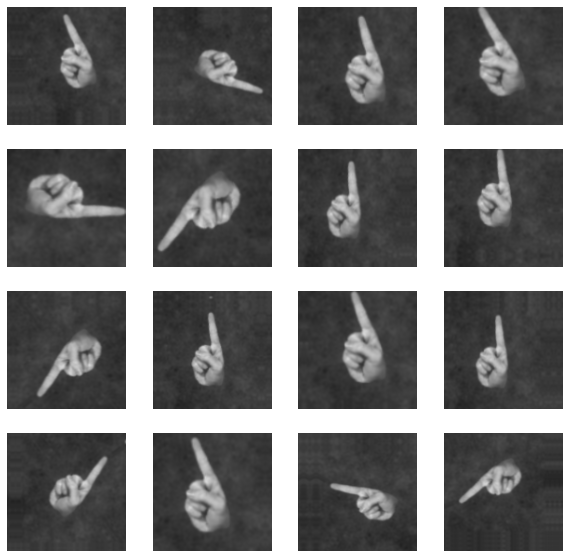

In [ ]:
plt.figure(figsize = (10,10))

for image, label in training_set.take(1):
  im = image[1]
  for i in range(0,16):
    plt.subplot(4,4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(im,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

plt.show()

In [ ]:
data_augmentation.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1))

# Build the CNN

### Building the custom model

In [ ]:
Input_shape_n = Image_size + (3,)

In [ ]:
Model = tf.keras.Sequential()
Model.add(data_augmentation)
Model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu', input_shape = Input_shape_n))
Model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu'))
Model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
Model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu'))
Model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'valid'))
Model.add(tf.keras.layers.Flatten())
Model.add(tf.keras.layers.Dropout(0.3))
Model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
Model.add(tf.keras.layers.Dense(units = 12, activation = 'softmax'))

In [ ]:
Model.compile(optimizer= 'Adam', 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [ ]:
loss0, accuracy0 = Model.evaluate(validation_set)

22/22 [==============================] - 1s 30ms/step - loss: 2.4934 - accuracy: 0.0881


In [ ]:
Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)            

In [ ]:
checkpoint_dir = '/content/checkpoints/cpkt_{epoch}'

cp_callback = tf.keras.callbacks.ModelCheckpoint( filepath = checkpoint_dir, save_weights_only= True )

In [ ]:
History = Model.fit(training_set, validation_data = validation_set, epochs = 20, callbacks = [cp_callback])

Epoch 1/20
563/563 [==============================] - 52s 78ms/step - loss: 1.4180 - accuracy: 0.4412 - val_loss: 1.4754 - val_accuracy: 0.4588
Epoch 2/20
563/563 [==============================] - 43s 77ms/step - loss: 0.5149 - accuracy: 0.7973 - val_loss: 0.9300 - val_accuracy: 0.6051
Epoch 3/20
563/563 [==============================] - 43s 77ms/step - loss: 0.3119 - accuracy: 0.8819 - val_loss: 0.8476 - val_accuracy: 0.6534
Epoch 4/20
563/563 [==============================] - 43s 77ms/step - loss: 0.2448 - accuracy: 0.9037 - val_loss: 0.6079 - val_accuracy: 0.7940
Epoch 5/20
563/563 [==============================] - 43s 77ms/step - loss: 0.2114 - accuracy: 0.9216 - val_loss: 0.6680 - val_accuracy: 0.7372
Epoch 6/20
563/563 [==============================] - 43s 77ms/step - loss: 0.1823 - accuracy: 0.9326 - val_loss: 0.2432 - val_accuracy: 0.9048
Epoch 7/20
563/563 [==============================] - 44s 77ms/step - loss: 0.1709 - accuracy: 0.9349 - val_loss: 0.6761 - val_accuracy:

In [ ]:
metrics=pd.DataFrame(History.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.417981,0.441222,1.475357,0.458807
1,0.514874,0.797278,0.930002,0.605114
2,0.311906,0.881944,0.847575,0.653409
3,0.244769,0.903667,0.607864,0.794034
4,0.211398,0.921611,0.668035,0.737216
5,0.182283,0.932611,0.243197,0.904830
6,0.170882,0.934944,0.676077,0.796875
7,0.146224,0.946000,0.043379,0.991477
8,0.154116,0.944500,0.104933,0.961648
9,0.136645,0.950444,0.030970,0.994318


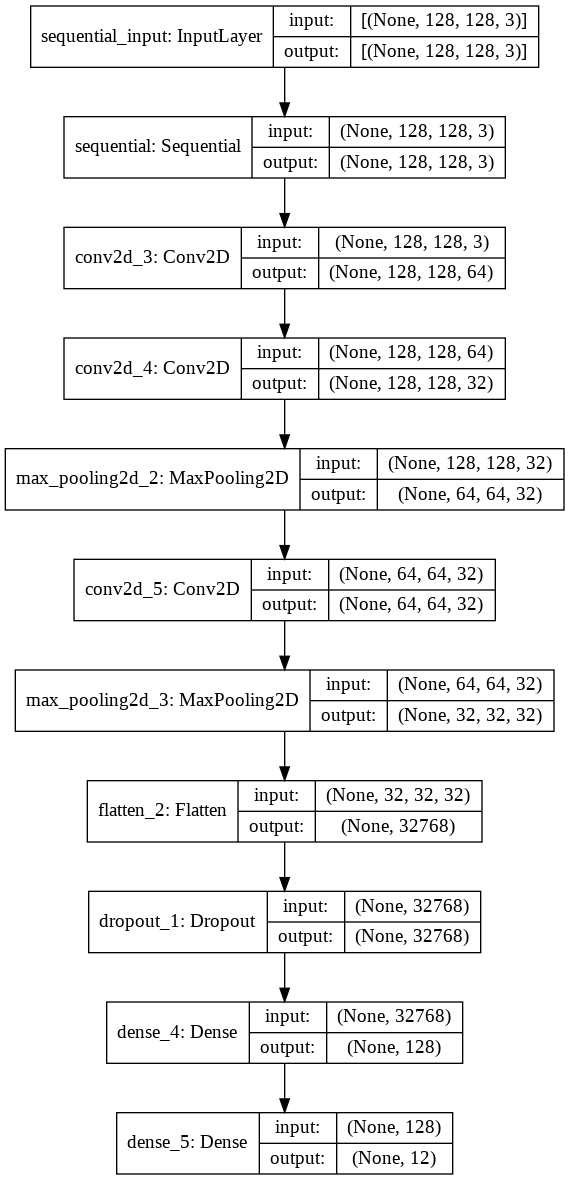

In [ ]:
#Our model Plot Model
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(Model, to_file=dot_img_file, show_shapes=True)

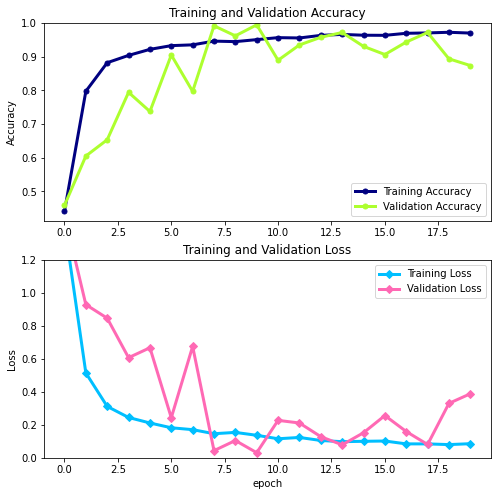

In [ ]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

loss = History.history['loss']
val_loss = History.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 3, marker = 'o', ms = 5, color = 'navy')
plt.plot(val_acc, label='Validation Accuracy',linewidth = 3, marker = 'o', ms = 5, color = 'greenyellow')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',linewidth = 3, marker = 'D', ms = 5, color = 'deepskyblue')
plt.plot(val_loss, label='Validation Loss',linewidth = 3, marker = 'D', ms = 5, color = 'hotpink')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
Model.evaluate(test_set)

91/91 [==============================] - 3s 26ms/step - loss: 0.0170 - accuracy: 0.9962


[0.016986867412924767, 0.9962016344070435]

## Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = Model.predict(class_name) 
y_pred =np.argmax(predictions, axis=1)

In [ ]:
test_set
y_pred

In [ ]:
import seaborn as sn

mat = confusion_matrix(test_set, y_pred)
plt.figure(figsize=(10,8))
sn.heatmap(mat, annot=True, fmt="d", cmap='viridis');

# Saving the model

In [ ]:
if not os.path.exists('/content/SavedModel'):
  os.mkdir('/content/SavedModel')

In [ ]:
Model.save('/content/SavedModel/Fingers.h5')

# Build CNN - ResNet 50



###  Building the model using ResNet 50

In [ ]:
resnet_model = tf.keras.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=12,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(128, activation='relu'))
resnet_model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 23,851,532
Trainable params: 263,820
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer= 'Adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

# (lr=0.001)

In [ ]:
loss0, accuracy0 = resnet_model.evaluate(validation_set)

22/22 [==============================] - 5s 86ms/step - loss: 3.3496 - accuracy: 0.0327


In [ ]:
history = resnet_model.fit(training_set, validation_data= validation_set, epochs=10)

Epoch 1/10
563/563 [==============================] - 54s 90ms/step - loss: 0.2179 - accuracy: 0.9276 - val_loss: 0.0500 - val_accuracy: 0.9872
Epoch 2/10
563/563 [==============================] - 50s 89ms/step - loss: 0.0438 - accuracy: 0.9874 - val_loss: 0.0388 - val_accuracy: 0.9872
Epoch 3/10
563/563 [==============================] - 51s 90ms/step - loss: 0.0289 - accuracy: 0.9920 - val_loss: 0.0142 - val_accuracy: 0.9957
Epoch 4/10
563/563 [==============================] - 50s 88ms/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0223 - val_accuracy: 0.9943
Epoch 5/10
563/563 [==============================] - 50s 89ms/step - loss: 0.0266 - accuracy: 0.9911 - val_loss: 0.0097 - val_accuracy: 0.9986
Epoch 6/10
563/563 [==============================] - 49s 88ms/step - loss: 0.0157 - accuracy: 0.9957 - val_loss: 0.0033 - val_accuracy: 0.9986
Epoch 7/10
563/563 [==============================] - 50s 88ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0144 - val_accuracy:

In [ ]:
metrics=pd.DataFrame(history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.217856,0.927611,0.049968,0.987216
1,0.043783,0.987389,0.038840,0.987216
2,0.028900,0.992000,0.014184,0.995739
3,0.014501,0.995389,0.022256,0.994318
4,0.026600,0.991056,0.009696,0.998580
5,0.015680,0.995667,0.003261,0.998580
6,0.011708,0.996889,0.014438,0.994318
7,0.023647,0.993944,0.001928,1.000000
8,0.002124,0.999278,0.005707,0.998580
9,0.000482,0.999944,0.000379,1.000000


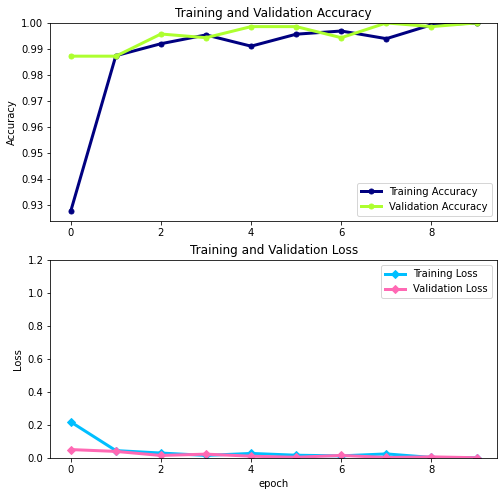

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 3, marker = 'o', ms = 5, color = 'navy')
plt.plot(val_acc, label='Validation Accuracy',linewidth = 3, marker = 'o', ms = 5, color = 'greenyellow')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',linewidth = 3, marker = 'D', ms = 5, color = 'deepskyblue')
plt.plot(val_loss, label='Validation Loss',linewidth = 3, marker = 'D', ms = 5, color = 'hotpink')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
training_set

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 12)), types: (tf.float32, tf.float32)>

## Saving the ResNet 50 model

In [ ]:
# save the Model weights

if not os.path.exists('/content'):
  os.mkdir('/content')

resnet_model.save('/content/Fingers_resnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
training_set

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 12)), types: (tf.float32, tf.float32)>